# Freight Synthesis

This notebook simulates freight trips and generates a freight population file.

The following steps are undertaken:

1. [Read, process, and plot data](#1-read-process-plot-data)
2. [Input Assumptions & Sampler Creation](#2-input-assumptions)
3. [Create Activity Model & Population](#3-activity-modeller)
4. [Validation](#4-validation)

In [1]:
import os
from datetime import date

import geopandas as gp
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pam.core import Household, Person, Population
from pam.samplers import tour
from pam.samplers.facility import FacilitySampler

matplotlib.style.use("ggplot")

In [2]:
output_path = "./data/outputs"

## 1. Read, process, plot Data
Below, we load in data required to build a tour plan: zones and facilities data.

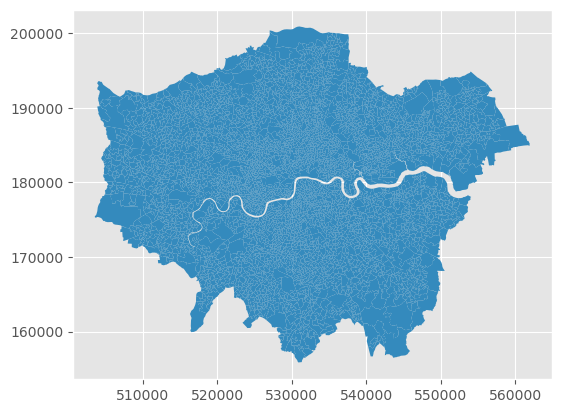

In [3]:
zones = gp.read_file("./data/lsoas/LSOA_2004_London_Low_Resolution.shp")
zones = zones.set_crs("EPSG:27700", allow_override=True)
zones = zones.rename(columns={"LSOA_CODE": "zone"})
zones.plot()
plt.show()

<Axes: >

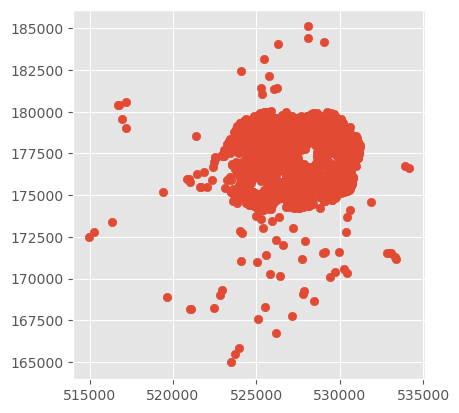

In [4]:
# load facilities
facilities = gp.read_file("./data/londinium_facilities_sample.geojson")
facilities = facilities.set_crs("EPSG:27700", allow_override=True)

# dummy create depots and deliveries
facilities["activity"] = np.where(facilities["activity"] == "shop", "depot", facilities["activity"])
facilities["activity"] = np.where(
    facilities["activity"] == "leisure", "delivery", facilities["activity"]
)

facilities.plot()

The zones data is for all of London, below, we crop the zones data to the Londinium study area.

In [5]:
cols = list(zones.columns)

zones_londinium = gp.sjoin(zones, facilities, how="inner", predicate="intersects")
zones_londinium = zones_londinium[cols]
zones = zones_londinium.drop_duplicates()
zones = zones.set_index("zone")

In [6]:
facility_sampler = FacilitySampler(
    facilities=facilities, zones=zones, build_xml=True, fail=False, random_default=True
)

facility_sampler.activities

Joining facilities data to zones, this may take a while.
Building sampler, this may take a while.


['home',
 'gym',
 'pub',
 'other',
 'transit',
 'delivery',
 'depot',
 'park',
 'work',
 'education',
 'medical']

In [7]:
# Create a facility zone dataset to be used in samplers
facility_zone = gp.sjoin(facilities, zones, how="inner", predicate="intersects")
facility_zone = facility_zone.rename(columns={"index_right": "zone"})
facility_zone = facility_zone.set_index("zone")

## 2. Input Assumptions
We create a series of samplers that will serve as inputs into the activity model. These samplers include:
- Number of Stops
- Freight Hourly Demand
- Origin (in this case, Depot) location

#### Number of Stops
Build a Stop Number distribution and corresponding sampler.

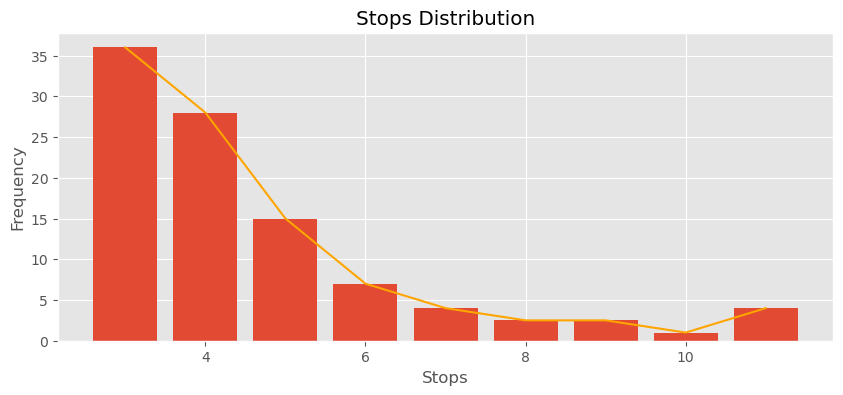

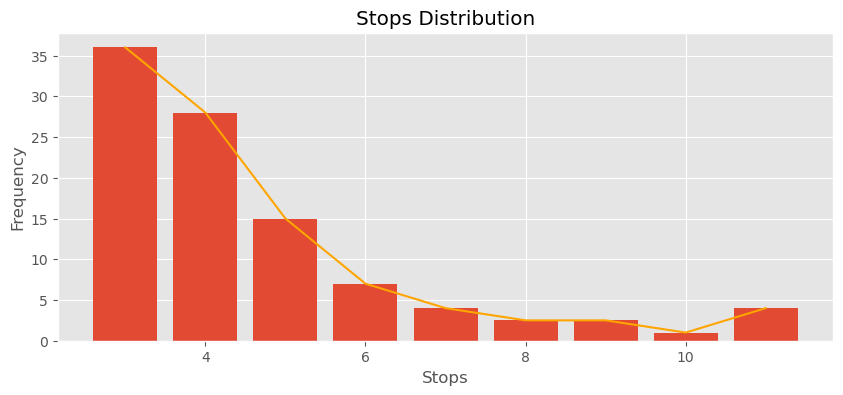

In [8]:
bins = range(3, 12)
pivots = {3: 36.0, 4: 28.0, 5: 15.0, 6: 7.0, 7: 4.0, 8: 2.5, 9: 2.5, 10: 1.0, 11: 4.0}
stop_sampler = tour.PivotDistributionSampler(bins=bins, pivots=pivots)
stop_sampler.plot(plot_title="Stops Distribution", x_label="Stops", y_label="Frequency")

#### Freight Hourly Demand
Hourly demand is a distribution created based on the pivots input. We use the class PivotDistributionSampler to translate 'pivots' into a distribution, plot, and sampler.

In [9]:
# Set up freight params for both LGV and HGV movements
lgv_params = {
    "total": 2500,
    "pivots": {
        7: 14,
        8: 9,
        9: 13,
        10: 16,
        11: 18,
        12: 13,
        13: 15,
        14: 16,
        15: 14,
        16: 13,
        17: 9,
        18: 5,
        19: 3,
        20: 3,
        21: 3,
        22: 2,
    },
    "agent_id": "LGV",
    "agent_attributes": "lgv",
}

Below, we decide if we will use the LGV or HGV parameters defined above.

In [10]:
freight_params = lgv_params.copy()

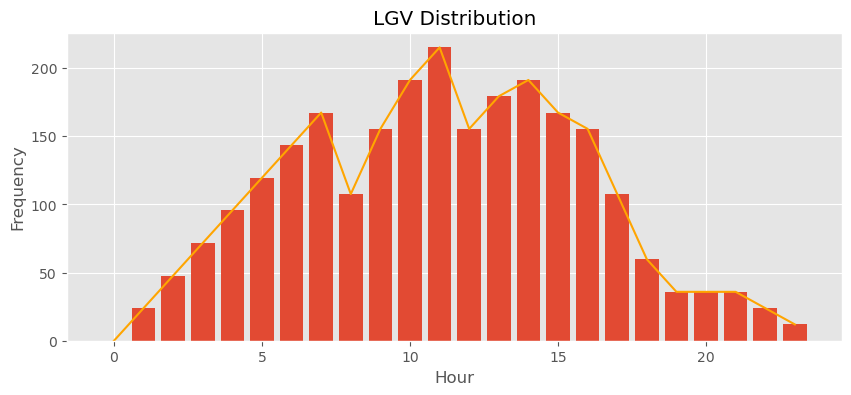

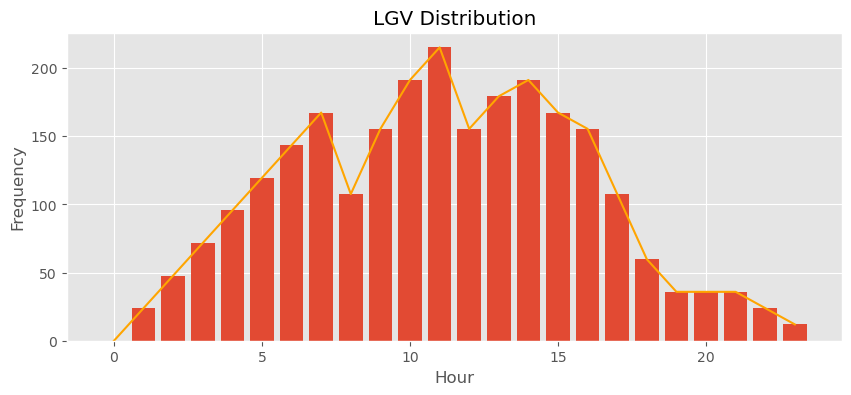

In [11]:
# Create Distribution
bins = range(0, 24)

hour_sampler = tour.PivotDistributionSampler(
    bins=bins, pivots=freight_params["pivots"], total=freight_params["total"]
)
hour_sampler.plot(
    plot_title=f"{freight_params['agent_id']} Distribution", x_label="Hour", y_label="Frequency"
)

In [12]:
# Create a minute sampler
minute_sampler = tour.FrequencySampler(range(60))
minute_sampler.sample()

12

#### Input Demand & Constraints
We calculate the density of depots and deliveries across all zones. This information will be utilised by the class FrequencySampler to create a distribution. We also create an origin/destination matrix of distances between centroids that will be used to selected the destination locations.

In [13]:
origin_density = tour.create_density_gdf(
    facility_zone=facility_zone, zone=zones, activity=["depot"]
)
destination_density = tour.create_density_gdf(
    facility_zone=facility_zone, zone=zones, activity=["delivery"]
)

In [14]:
# Input Demand, in this case defined as facility density location
depot_sampler = tour.FrequencySampler(origin_density.index, origin_density.density)

In [15]:
# Constraint, defined as distance between origin and destination centroids. This dataframe will be filtered based on threshold values defined later.
zones_list = np.array(zones.centroid.apply(lambda x: [x.x, x.y]).to_list())
od_matrix = np.linalg.norm(zones_list[:, None, :] - zones_list[None, :, :], axis=-1)
df_od = pd.DataFrame(od_matrix, index=zones.index, columns=zones.index)

## 3. Activity Modeller

Parameters are defined to model a population of activity plans. Activities are encoded as "car". Subpopulation is encoded as "lgv" or "hgv".

#### Population Parameters

In [16]:
# Factor to scale trips (To better match validation counts when needed)
factor = 1

# Sample Size
samples = [0.1]  # increase

# Set Distance threshold, in this case arbitrarily set to median distance of od dataframe.
threshold_value = df_od.median().agg("median")

# used for fnames
today = date.today().strftime("%d%b%y")
today

'04Sep23'

#### Activity Modeller

In [17]:
#### Sample Agents


def sample_agents(size):
    facility_sampler.clear()
    population = Population()

    for i in range(size):
        agent_id = f"{freight_params['agent_id']}_{i}"
        hh = Household(agent_id)

        agent = Person(
            agent_id,
            freq=100,
            attributes={
                "subpopulation": freight_params["agent_attributes"],
                "CarType": freight_params["agent_attributes"],
                "CarCO2": freight_params["agent_attributes"],
            },
        )

        hh.add(agent)
        population.add(hh)

        hour = hour_sampler.sample()
        minute = minute_sampler.sample()
        o_zone = depot_sampler.sample()

        stops = stop_sampler.sample() if freight_params["agent_id"] == "LGV" else 1

        agent_plan = tour.TourPlanner(
            stops=stops,
            hour=hour,
            minute=minute,
            o_zone=o_zone,
            d_dist=destination_density,
            d_freq="density",
            threshold_matrix=df_od,
            threshold_value=threshold_value,
            facility_sampler=facility_sampler,
            activity_params={"o_activity": "depot", "d_activity": "delivery"},
        )

        o_loc, d_zones, d_locs = agent_plan.sequence_stops()
        agent_plan.apply(agent=agent, o_loc=o_loc, d_zones=d_zones, d_locs=d_locs)

    return population

In [18]:
# Function to build population


def build_population(sample, factor):
    population = sample_agents(int(factor * int(freight_params["total"] * sample)))

    return population

In [19]:
# Build + Crop + Write Population for samples
for s in samples:
    # build
    population = build_population(s, factor)

    # # Crop and Validate Plans
    population.fix_plans()
    population.validate()

    # # Write to Disk
    xml_comment = f"prelim {s*100}% {freight_params['agent_id']} {today}"
    output_path = os.path.join(output_path)

    population.to_csv(output_path, crs="EPSG:27700", to_crs="EPSG:4326")

## 4. Validation

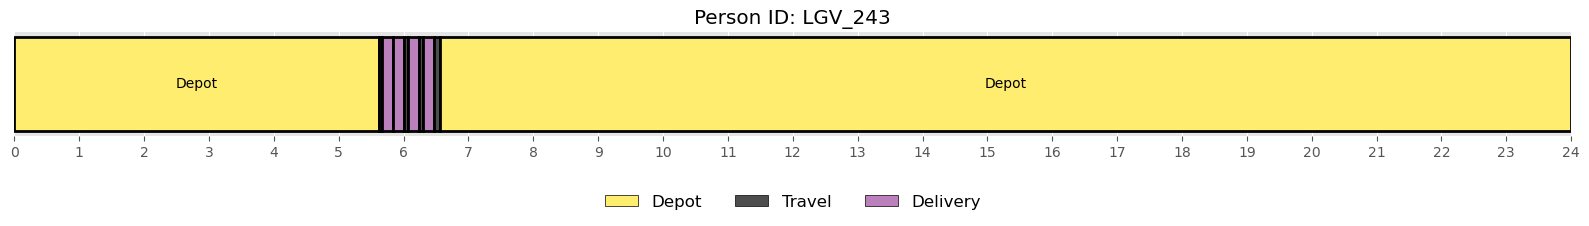

In [20]:
population.random_person().plot()

In [21]:
trips = pd.read_csv(os.path.join(output_path, "legs.csv"))


def get_hour(dt):
    return int(dt.split(" ")[1].split(":")[0])


trips["start_hour"] = trips["tst"].apply(get_hour)

In [22]:
freight_density = tour.ValidateTourOD(
    trips=trips,
    zone=zones,
    o_dist=origin_density,
    d_dist=destination_density,
    o_activity="depot",
    d_activity="delivery",
    o_freq="density",
    d_freq="density",
)

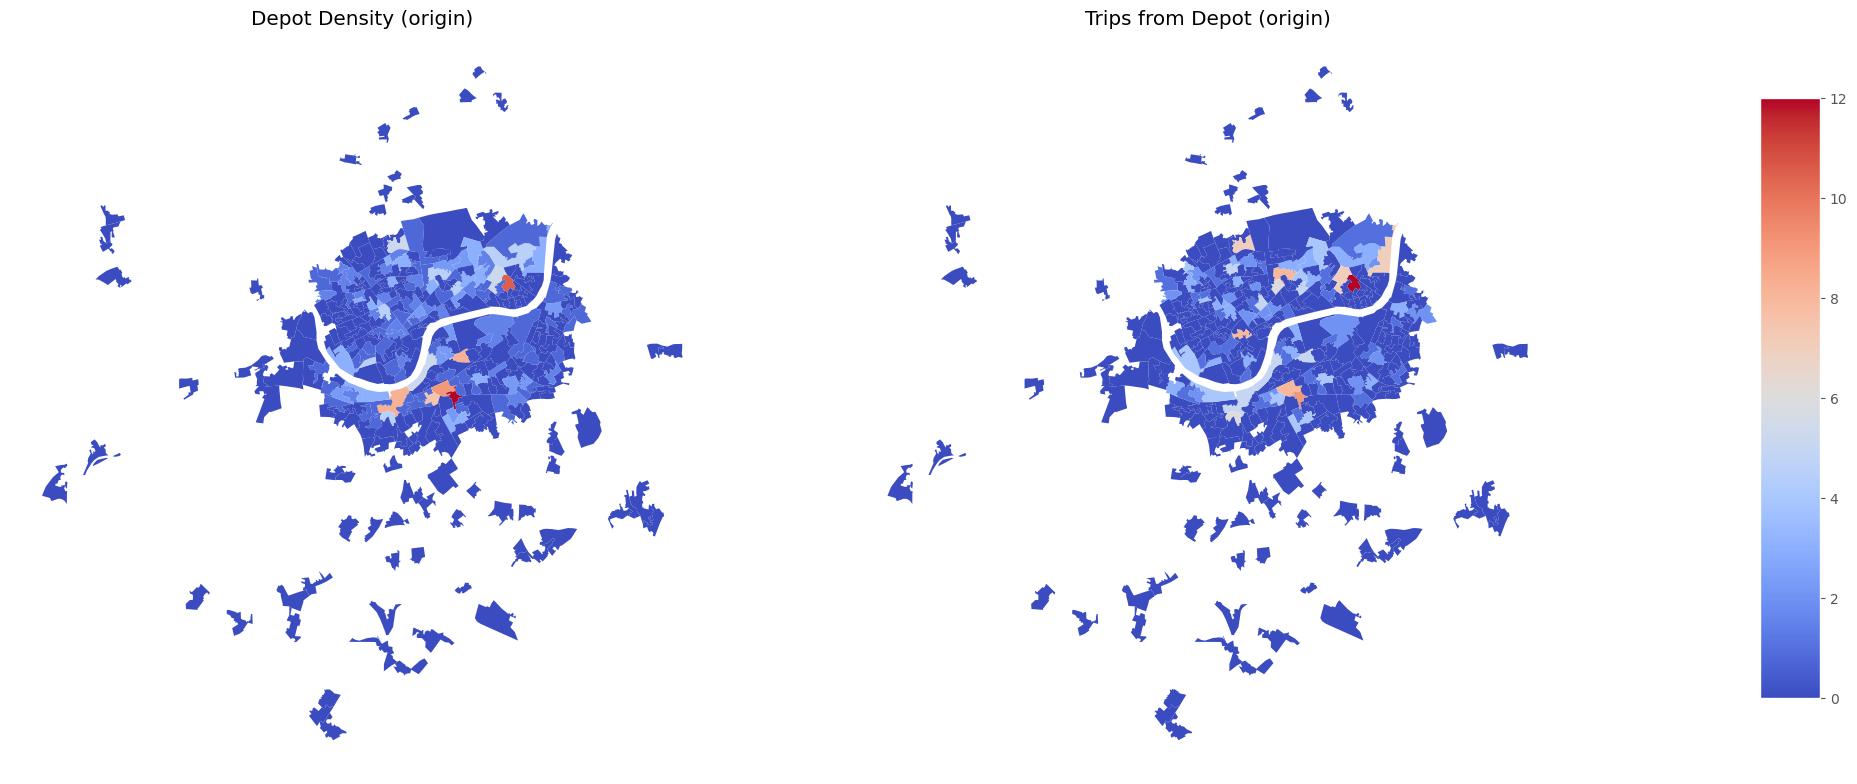

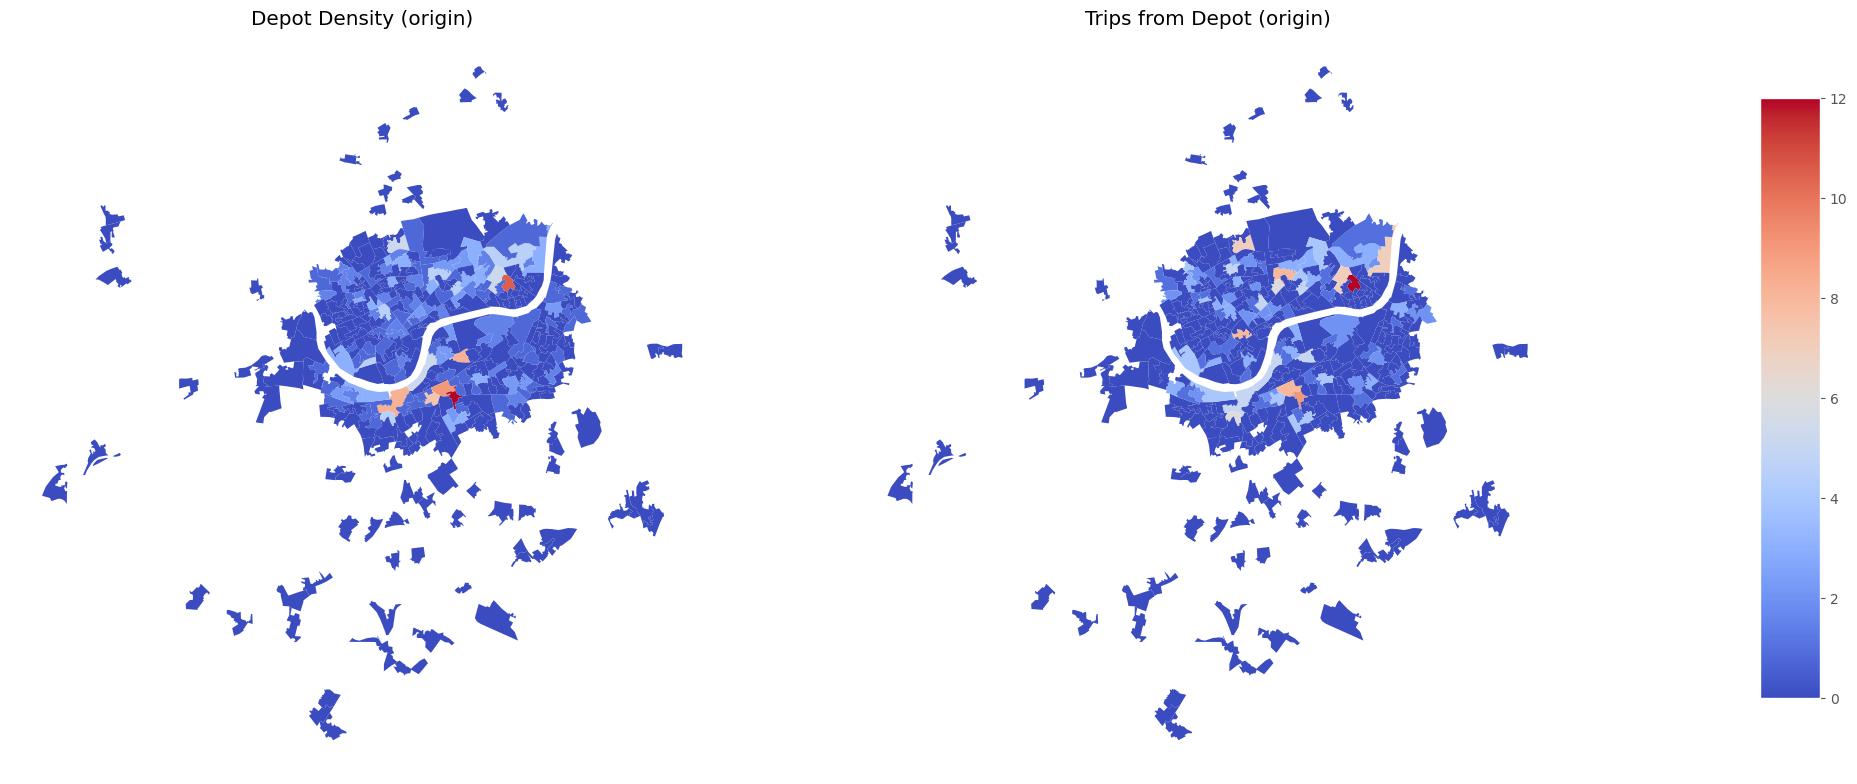

In [23]:
freight_density.plot_validate_spatial_density(
    title_1="Depot Density (origin)",
    title_2="Trips from Depot (origin)",
    density_metric="depot_density",
    density_trips="origin_trips",
)

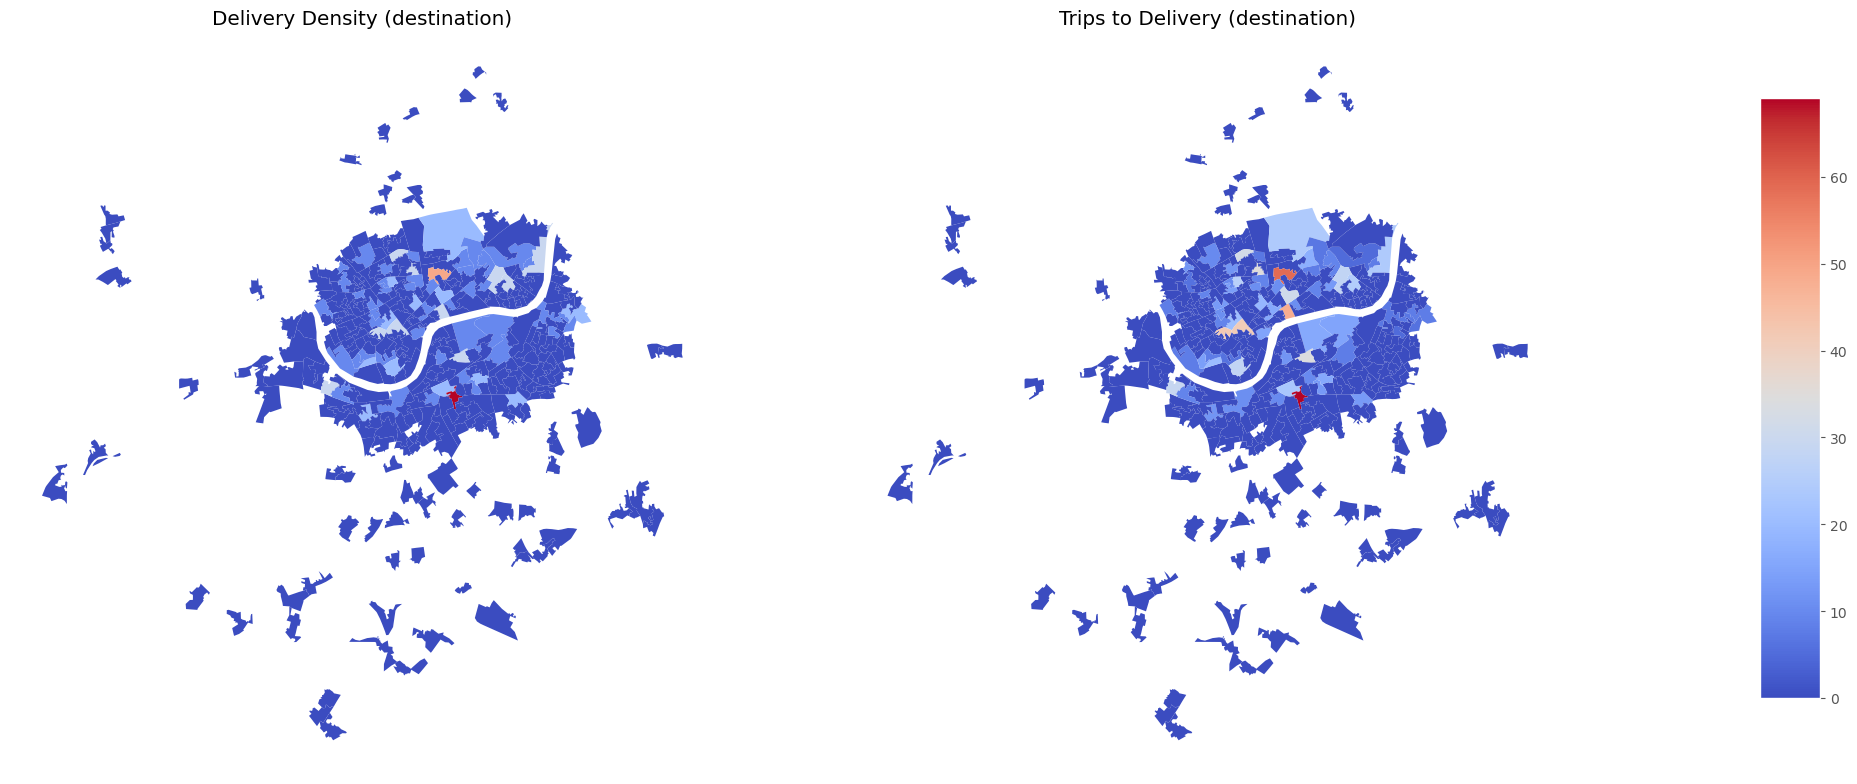

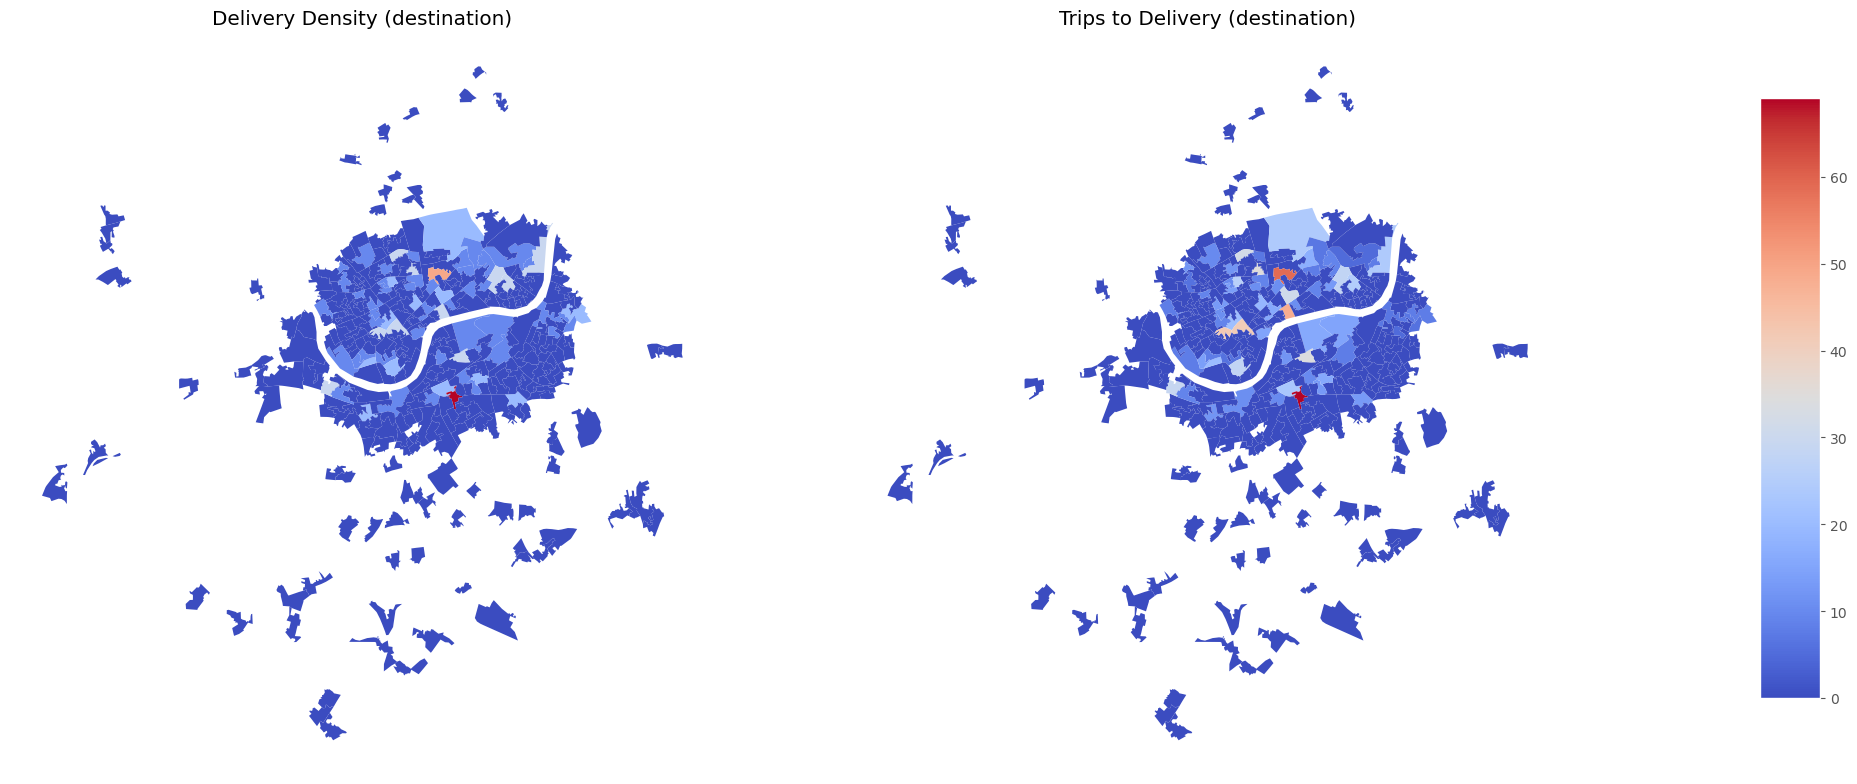

In [24]:
freight_density.plot_validate_spatial_density(
    title_1="Delivery Density (destination)",
    title_2="Trips to Delivery (destination)",
    density_metric="delivery_density",
    density_trips="destination_trips",
)

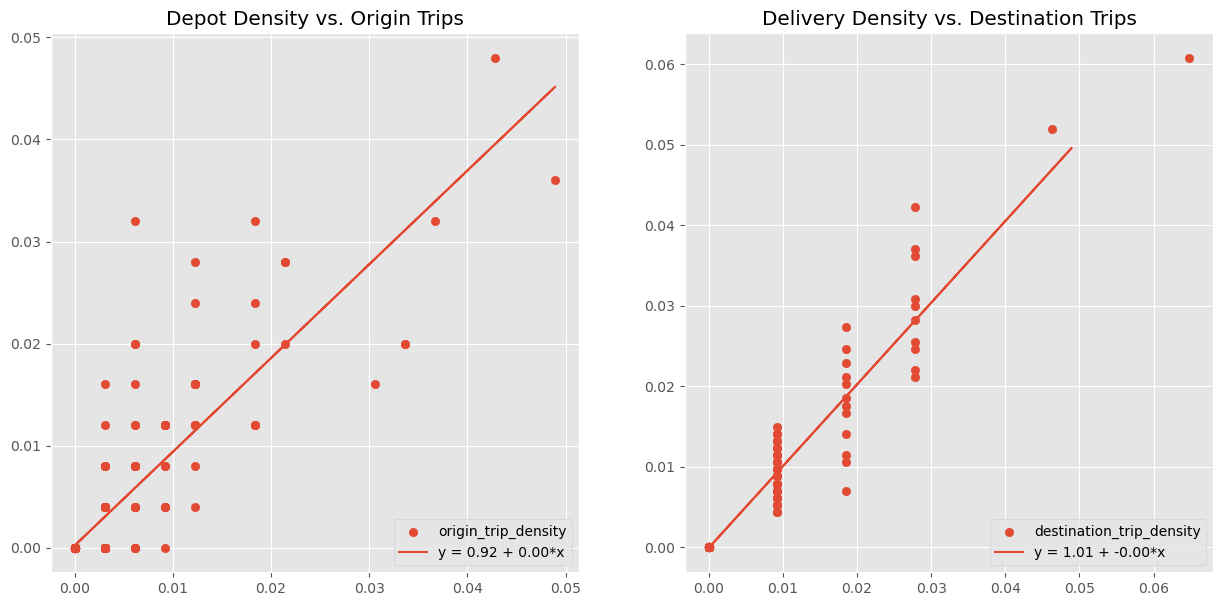

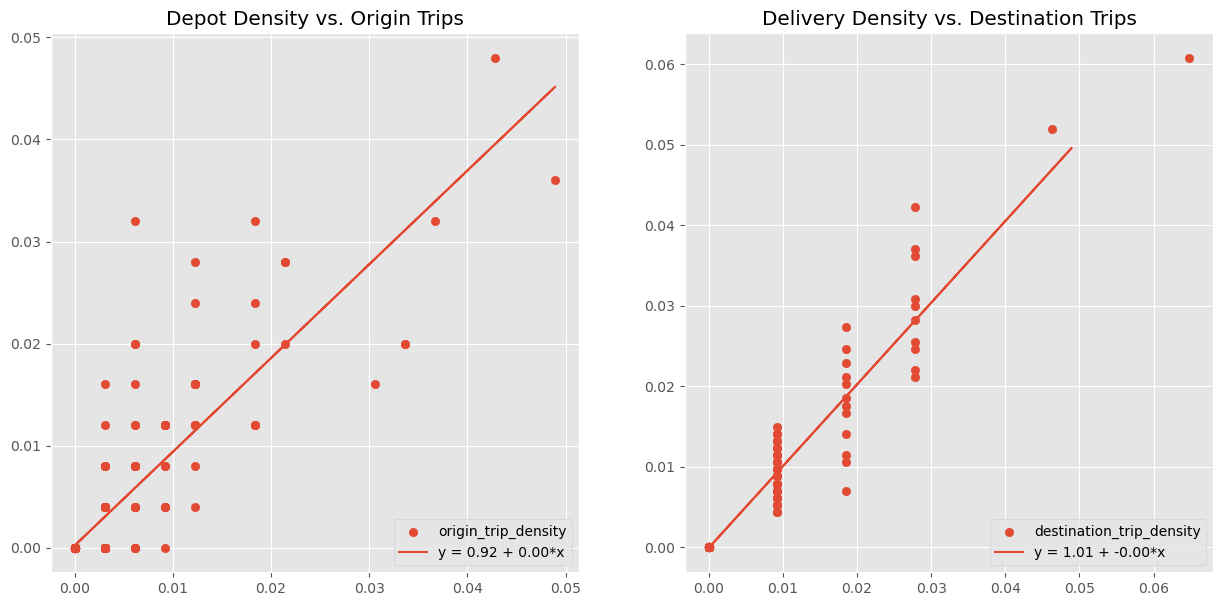

In [25]:
freight_density.plot_compare_density(
    title_1="Depot Density vs. Origin Trips",
    title_2="Delivery Density vs. Destination Trips",
    o_activity="depot_density",
    d_activity="delivery_density",
)